# part1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
path = './/calib_imgs//1'

left_images = []
right_images = []
left_gray = []
right_gray = []
filenames = glob(f'{path}//left*')
for filename in filenames:
    img = cv2.imread( filename , cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    left_images.append(img)
    
filenames = glob(f'{path}//right*')
for filename in filenames:
    img = cv2.imread( filename , cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    right_images.append(img)
    
left_points = []
right_points = []

data_num = len(left_images)
#print(data_num)

obj_points = []

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for i in range( data_num ):
    
    img = left_images[i]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    left_chessboard , left_corners = cv2.findChessboardCorners(left_images[i], (6, 9) )
    corners2 = cv2.cornerSubPix(gray,left_corners,(11,11),(-1,-1),criteria)
    left_points.append(corners2)
    left_gray.append(gray)
    
    img = right_images[i]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    right_chessboard , right_corners = cv2.findChessboardCorners(right_images[i], (6, 9) )
    corners2 = cv2.cornerSubPix(gray,right_corners,(11,11),(-1,-1),criteria)
    right_points.append(corners2)
    right_gray.append(gray)
    
    objp = np.zeros((6*9 , 3) , dtype = np.float32)
    objp[ : , 0:2] = np.mgrid[0:6 , 0:9].T.reshape(-1,2)
    obj_points.append(objp)

In [2]:
ret1 , intrinsic1 , dist1 , rotation1, translation1 = cv2.calibrateCamera(obj_points, left_points, left_gray[0].shape[::-1],None,None)
ret2 , intrinsic2 , dist2 , rotation2 , translation2 = cv2.calibrateCamera(obj_points,right_points, right_gray[0].shape[::-1],None,None)

In [3]:
print("intrinsic1 (left camera)")
print(intrinsic1)
print("")
print("intrinsic2 (right camera)")
print(intrinsic2)

intrinsic1 (left camera)
[[465.348904     0.         316.23815712]
 [  0.         465.23975271 186.90774079]
 [  0.           0.           1.        ]]

intrinsic2 (right camera)
[[467.36026835   0.         329.81086723]
 [  0.         466.95932266 176.98373906]
 [  0.           0.           1.        ]]


# Part2 

In [4]:
if True:
    i = 0
    R_left = np.array(rotation1[i])
    R_left = cv2.Rodrigues(R_left)    
    T_left = np.array(translation1[i])
    
    E_left = np.zeros((4,4),dtype = np.float)
    E_left[0:3 , 0:3] = R_left[0]
    E_left[0:3 , 3] = T_left.T
    E_left[3 , 3] = 1.0
    
    R_right = np.array(rotation1[i])
    R_right = cv2.Rodrigues(R_right)
    T_right = np.array(translation2[i])
    
    E_right = np.zeros((4,4),dtype = np.float)
    E_right[0:3 , 0:3] = R_right[0]
    E_right[0:3 , 3] = T_right.T
    E_right[3 , 3] = 1.0
    
    E_r2l = E_right @ np.linalg.inv(E_left)
    print("the transformation relates points in the right camera coord to the left camera coord")
    print(E_r2l)
    
    R_r2l = E_r2l[0:3 ,0:3]
    T_r2l = E_r2l[0:3 ,3]
    K_old_left = intrinsic1
    K_old_right = intrinsic2
    
    x = T_r2l / np.linalg.norm(T_r2l)
    y = np.cross(np.array([0,0,1.0]) , x )
    y /= np.linalg.norm(y)
    z = np.cross(x,y)
    R =  np.vstack((x,y,z))
    K_new = K_old_left
    #K_new[0:2 , 2] = 0
    
    H1 = K_new @ R   @ np.linalg.inv(intrinsic1)
    #H1 = np.abs(H1)

    H2 = K_new @ R  @ R_r2l @ np.linalg.inv(intrinsic2)
    print("H1")
    print(H1)
    print("H2")
    print(H2)
    

the transformation relates points in the right camera coord to the left camera coord
[[ 1.00000000e+00  8.67361738e-19  1.38777878e-17 -3.62521257e+00]
 [ 1.73472348e-18  1.00000000e+00 -2.56142763e-17 -1.06715499e-01]
 [-1.38777878e-17 -2.62647976e-17  1.00000000e+00  2.04670842e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
H1
[[-9.59706235e-01 -2.82575312e-02  6.50732471e+02]
 [ 5.20380028e-02 -9.98900972e-01  3.56856749e+02]
 [ 1.21025583e-04  3.56346980e-06  9.59472495e-01]]
H2
[[-9.55575976e-01 -2.81534733e-02  6.62097237e+02]
 [ 5.18140484e-02 -9.95222536e-01  3.45660196e+02]
 [ 1.20504729e-04  3.55034739e-06  9.58039319e-01]]


# Part3

rectified picture (left camera)


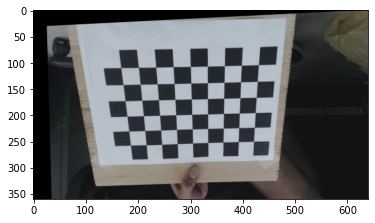

rectified picture (right camera)


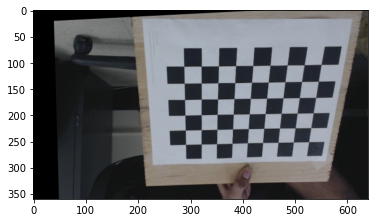

In [5]:
 if True:
    i=0
    col , row , k= left_images[0].shape
    output = cv2.warpPerspective(left_images[i], H1, (row , col))
    left_images[i] = output
    print("rectified picture (left camera)")
    plt.figure()
    plt.imshow(output)
    plt.show()
    #print(left_images[i].shape)
    #plt.imshow(left_images[i])

    col , row , k= right_images[i].shape
    output = cv2.warpPerspective(right_images[i], H2, (row , col))
    right_images[i] = output
    print("rectified picture (right camera)")
    plt.figure()
    plt.imshow(output)
    plt.show()

In [6]:
for i in range(data_num):
    
    R_left = np.array(rotation1[i])
    R_left = cv2.Rodrigues(R_left)    
    T_left = np.array(translation1[i])
    
    E_left = np.zeros((4,4),dtype = np.float)
    E_left[0:3 , 0:3] = R_left[0]
    E_left[0:3 , 3] = T_left.T
    E_left[3 , 3] = 1.0
    
    R_right = np.array(rotation1[i])
    R_right = cv2.Rodrigues(R_right)
    T_right = np.array(translation2[i])
    
    E_right = np.zeros((4,4),dtype = np.float)
    E_right[0:3 , 0:3] = R_right[0]
    E_right[0:3 , 3] = T_right.T
    E_right[3 , 3] = 1.0
    
    E_r2l = E_right @ np.linalg.inv(E_left)

    R_r2l = E_r2l[0:3 ,0:3]
    T_r2l = E_r2l[0:3 ,3]
    K_old_left = intrinsic1
    K_old_right = intrinsic2
    
    x = T_r2l / np.linalg.norm(T_r2l)
    y = np.cross(np.array([0,0,1.0]) , x )
    y /= np.linalg.norm(y)
    z = np.cross(x,y)
    R =  np.vstack((x,y,z))
    K_new = K_old_left
    #K_new[0:2 , 2] = 0
    
    H1 = K_new @ R   @ np.linalg.inv(intrinsic1)
    #H1 = np.abs(H1)

    H2 = K_new @ R  @ R_r2l @ np.linalg.inv(intrinsic2)
    #print(H1)
    #print(H2)
    col , row , k= left_images[0].shape
    output = cv2.warpPerspective(left_images[i], H1, (row , col))
    left_images[i] = output
    #print("rectified picture (left camera)")
    #plt.figure()
    #plt.imshow(output)
    #plt.show()
    #print(left_images[i].shape)
    #plt.imshow(left_images[i])

    col , row , k= right_images[i].shape
    output = cv2.warpPerspective(right_images[i], H2, (row , col))
    right_images[i] = output
    #print("rectified picture (right camera)")
    #plt.figure()
    #plt.imshow(output)
    #plt.show()
    #print(right_images[i].shape)
    #plt.imshow(right_images[i])

In [7]:

left_gray = []
right_gray = []
left_points = []
right_points = []

data_num = len(left_images)
#print(data_num)

obj_points = []
for i in range( data_num ):
    
    img = left_images[i]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    left_chessboard , left_corners = cv2.findChessboardCorners(left_images[i], (6, 9) )
    corners2 = cv2.cornerSubPix(gray,left_corners,(11,11),(-1,-1),criteria)
    left_points.append(corners2)
    left_gray.append(gray)
    
    img = right_images[i]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    right_chessboard , right_corners = cv2.findChessboardCorners(right_images[i], (6, 9) )
    corners2 = cv2.cornerSubPix(gray,right_corners,(11,11),(-1,-1),criteria)
    right_points.append(corners2)
    right_gray.append(gray)
    
    objp = np.zeros((6*9 , 3) , dtype = np.float32)
    objp[ : , 0:2] = np.mgrid[0:6 , 0:9].T.reshape(-1,2)
    obj_points.append(objp)

In [8]:
ret1 , intrinsic1 , dist1 , rotation1, translation1 = cv2.calibrateCamera(obj_points, left_points, left_gray[0].shape[::-1],None,None)
ret2 , intrinsic2 , dist2 , rotation2 , translation2 = cv2.calibrateCamera(obj_points,right_points, right_gray[0].shape[::-1],None,None)
print("intrinsic1")
print(intrinsic1)
print("")
print("intrinsic2")
print(intrinsic2)

intrinsic1
[[466.39373422   0.         317.32481478]
 [  0.         466.23341458 187.45789269]
 [  0.           0.           1.        ]]

intrinsic2
[[462.86887538   0.         318.10392362]
 [  0.         463.26215382 184.41411645]
 [  0.           0.           1.        ]]


In [9]:
for i in range(data_num):
    
    R_left = np.array(rotation1[i])
    R_left = cv2.Rodrigues(R_left)    
    T_left = np.array(translation1[i])
    
    E_left = np.zeros((4,4),dtype = np.float)
    E_left[0:3 , 0:3] = R_left[0]
    E_left[0:3 , 3] = T_left.T
    E_left[3 , 3] = 1.0
    
    R_right = np.array(rotation1[i])
    R_right = cv2.Rodrigues(R_right)
    T_right = np.array(translation2[i])
    
    E_right = np.zeros((4,4),dtype = np.float)
    E_right[0:3 , 0:3] = R_right[0]
    E_right[0:3 , 3] = T_right.T
    E_right[3 , 3] = 1.0
    
    E_r2l = E_right @ np.linalg.inv(E_left)
    print('E_r2l')
    print(E_r2l)

E_r2l
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -3.22977332e+00]
 [-6.93889390e-18  1.00000000e+00 -2.08166817e-17 -1.31978715e-01]
 [ 1.38777878e-17  1.47451495e-17  1.00000000e+00  1.91608771e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
E_r2l
[[ 1.00000000e+00 -6.93889390e-18  5.55111512e-17  3.66814336e+00]
 [ 6.93889390e-18  1.00000000e+00  1.73472348e-17  7.82689805e-02]
 [-5.55111512e-17  3.46944695e-17  1.00000000e+00 -4.81574033e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
E_r2l
[[ 1.00000000e+00  0.00000000e+00  1.38777878e-17  3.45085680e+00]
 [ 0.00000000e+00  1.00000000e+00  1.38777878e-17  1.43697514e-01]
 [ 1.38777878e-17 -3.12250226e-17  1.00000000e+00 -1.35001824e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
E_r2l
[[ 1.00000000e+00 -5.55111512e-17  0.00000000e+00  3.41996561e+00]
 [ 0.00000000e+00  1.00000000e+00 -6.93889390e-18  1.44192798e-01]
 [ 0.00000000e+00  6.24500451e-17  

the rotation part is an Identity matrix, in translation part, only the number of translation in x direction is greater than 0.5 so it could be taken as a translation along the x axis